##6-1. 프로젝트: CutMix 또는 Mixup 비교실험 하기

In [103]:
#주요 라이브러리 버전 확인
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.15.0
1.23.5


###1. Augmentation을 적용한 데이터셋 만들기

Q. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?<br>
답: CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

CutMix와 Mixup은 데이터 증강 기법으로, 훈련 데이터의 다양성을 증가시켜 모델의 일반화 능력을 향상시키는 데 사용한다.

In [104]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [105]:
#gpu환경확인하기
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [106]:
(ds_train, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [107]:
#ds_train과 ds_test 데이터셋이 튜플 형태인지 확인

import tensorflow as tf

# 첫 번째 요소를 추출하는 함수
def check_dataset_structure(ds):
    for example in ds.take(1):
        print("Data type:", type(example))
        if isinstance(example, tuple) and len(example) == 2:
            print("Dataset element is a tuple with two elements (image, label).")
        else:
            print("Dataset element is not a tuple with two elements.")

# ds_train과 ds_test의 구조 확인
print("Checking ds_train structure:")
check_dataset_structure(ds_train)

print("\nChecking ds_test structure:")
check_dataset_structure(ds_test)


Checking ds_train structure:
Data type: <class 'dict'>
Dataset element is not a tuple with two elements.

Checking ds_test structure:
Data type: <class 'dict'>
Dataset element is not a tuple with two elements.


In [108]:
for example in ds_train.take(1):
    print("Keys:", example.keys())
    print("Image data type:", type(example["image"]))
    print("Label data type:", type(example["label"]))
    break  # 첫 번째 요소만 확인하고 반복문을 종료


Keys: dict_keys(['image', 'label'])
Image data type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Label data type: <class 'tensorflow.python.framework.ops.EagerTensor'>


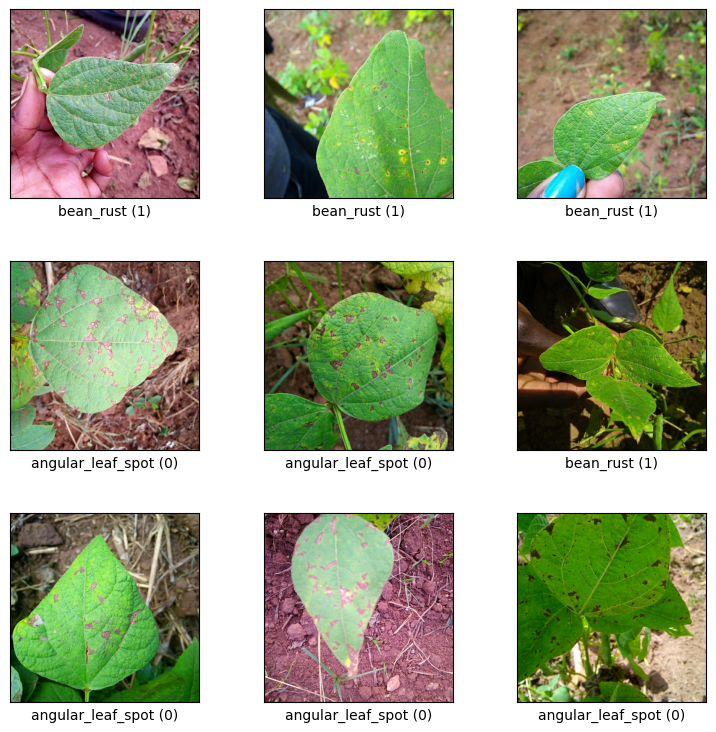

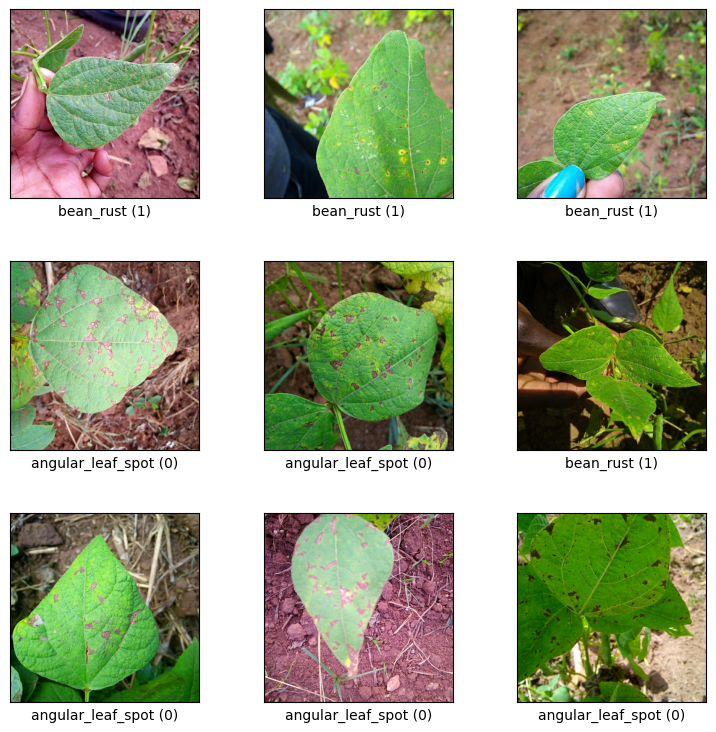

In [109]:
tfds.show_examples(ds_train, ds_info) #다운로드한 데이터 확인하기

In [110]:
# Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만들기
def normalize_and_resize_img(data):
    image = data['image']
    label = data['label']
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [111]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [112]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [113]:
#cutmix

import tensorflow as tf

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # 이미지 텐서를 float32 타입으로 변환
    image_a = tf.cast(image_a, tf.float32)
    image_b = tf.cast(image_b, tf.float32)

    # 마스크 텐서 생성 및 float32 타입으로 변환
    mask = tf.zeros_like(image_a, dtype=tf.float32)

    # 마스크 업데이트를 위한 영역 지정
    mask_height = y_max - y_min
    mask_width = x_max - x_min

    # 업데이트할 영역의 인덱스 생성
    mask_indices = tf.reshape(tf.stack([tf.range(y_min, y_max), tf.range(x_min, x_max)], axis=1), [-1, 2])
    mask_indices = tf.concat([mask_indices, tf.zeros((tf.shape(mask_indices)[0], 1), dtype=tf.int32)], axis=1)

    # 마스크 업데이트
    updates = tf.ones((mask_height, mask_width, 3), dtype=tf.float32)
    mask = tf.tensor_scatter_nd_update(mask, mask_indices, updates)

    # 이미지 혼합
    mixed_image = image_a * (1 - mask) + image_b * mask
    return mixed_image


def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, img_size, num_classes):
    # 혼합된 영역의 비율 계산
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = img_size * img_size
    mix_ratio = mixed_area / total_area

    # 라벨 혼합
    mixed_label = mix_ratio * label_a + (1 - mix_ratio) * label_b
    return mixed_label


# CutMix를 위한 박스 생성 함수
def get_clip_box(image_a, image_b):
    # 이미지 크기 가져오기
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # 박스의 중심 위치와 크기 결정
    rx = tf.random.uniform([], 0, image_size_x, dtype=tf.int32)
    ry = tf.random.uniform([], 0, image_size_y, dtype=tf.int32)
    rw = tf.random.uniform([], 0, tf.cast(image_size_x/2, tf.int32), dtype=tf.int32)
    rh = tf.random.uniform([], 0, tf.cast(image_size_y/2, tf.int32), dtype=tf.int32)

    # 박스의 경계 좌표 계산
    x_min = tf.clip_by_value(rx - rw // 2, 0, image_size_x)
    y_min = tf.clip_by_value(ry - rh // 2, 0, image_size_y)
    x_max = tf.clip_by_value(rx + rw // 2, 0, image_size_x)
    y_max = tf.clip_by_value(ry + rh // 2, 0, image_size_y)

    return x_min, y_min, x_max, y_max


# CutMix 함수
def cutmix(images, labels, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    if tf.random.uniform([]) > prob:
        return images, labels

    mixed_images = []
    mixed_labels = []

    for i in range(batch_size):
        image_a, label_a = images[i], labels[i]
        j = tf.random.uniform([], minval=0, maxval=batch_size, dtype=tf.int32)
        image_b, label_b = images[j], labels[j]

        # 라벨을 원-핫 인코딩으로 변환
        label_a = tf.one_hot(label_a, depth=num_classes)
        label_b = tf.one_hot(label_b, depth=num_classes)

        # CutMix 박스 가져오기 및 이미지 혼합
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
        mixed_images.append(mixed_img)

        # 라벨 혼합
        mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, img_size, num_classes)
        mixed_labels.append(mixed_label)

    return tf.stack(mixed_images), tf.stack(mixed_labels)



In [114]:
#mixup

def mixup_2_images(image_a, image_b, label_a, label_b, num_classes):
    # ratio를 float32 타입으로 명시적으로 변환
    ratio = tf.cast(tf.random.uniform([], 0, 1), tf.float32)

    # 이미지와 라벨을 float32 타입으로 변환
    image_a = tf.cast(image_a, tf.float32)
    image_b = tf.cast(image_b, tf.float32)
    label_a = tf.cast(label_a, tf.float32)
    label_b = tf.cast(label_b, tf.float32)

    # 이미지 혼합
    mixed_image = (1 - ratio) * image_a + ratio * image_b

    # 라벨 혼합
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label




def mixup(images, labels, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    if tf.random.uniform([]) > prob:
        return images, labels

    mixed_images = []
    mixed_labels = []

    for i in range(batch_size):
        j = tf.random.uniform([], minval=0, maxval=batch_size, dtype=tf.int32)

        # 라벨을 원-핫 인코딩으로 변환
        label_a = tf.one_hot(labels[i], depth=num_classes)
        label_b = tf.one_hot(labels[j], depth=num_classes)

        # 이미지 혼합
        mixed_img, mixed_label = mixup_2_images(images[i], images[j], label_a, label_b, num_classes)
        mixed_images.append(mixed_img)
        mixed_labels.append(mixed_label)

    return tf.stack(mixed_images), tf.stack(mixed_labels)


In [115]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    ds = ds.batch(batch_size)
    if not is_test:
        if with_cutmix:
            ds = ds.map(
                cutmix,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            )
        elif with_mixup:
            ds = ds.map(
                mixup,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            )
        else:
            ds = ds.map(
                onehot,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            )
        ds = ds.repeat()
        ds = ds.shuffle(200)
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

###2. 모델 만들기<br>
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [116]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras  # 여기에서 keras를 임포트합니다.

num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [117]:
#Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어줍니다.

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [118]:
def normalize_and_resize_img(data):
    image = data['image']
    label = data['label']
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [119]:
#cutmix 및 mixup 함수의 배치 크기 처리를 검증

import tensorflow as tf

# 테스트용 배치 데이터 생성 함수
def create_test_batch(batch_size=16, img_size=224, num_classes=120):
    images = tf.random.normal((batch_size, img_size, img_size, 3))
    labels = tf.random.uniform((batch_size,), minval=0, maxval=num_classes, dtype=tf.int32)
    return images, labels

# cutmix 및 mixup 함수 출력 확인 함수
def verify_batch_size(func, batch_size=16, img_size=224, num_classes=120):
    images, labels = create_test_batch(batch_size, img_size, num_classes)
    mixed_images, mixed_labels = func(images, labels, batch_size=batch_size, img_size=img_size, num_classes=num_classes)

    # 결과 배치 크기 확인
    assert mixed_images.shape[0] == batch_size, f"Expected batch size {batch_size}, got {mixed_images.shape[0]}"
    assert mixed_labels.shape[0] == batch_size, f"Expected batch size {batch_size}, got {mixed_labels.shape[0]}"
    print(f"{func.__name__}: Batch size verification passed!")

# cutmix 및 mixup 함수에 대해 검증 수행
verify_batch_size(cutmix)
verify_batch_size(mixup)


InvalidArgumentError: ignored

In [ ]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
#훈련 과정을 시각화 해봅시다.

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

In [ ]:
#조금 더 확대해 살펴봅시다.

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()